## Load Data

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

print('GPU name: ', tf.config.experimental.list_physical_devices('GPU'))

GPU name:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import pandas as pd
## Load Labels
df_all_data = pd.read_csv("./clean_processed_data.csv")
df_all_data = df_all_data.iloc[:,[0,1,2,-1]].copy()
df_all_data["file_seed"] = df_all_data["name"] + "-SEED-" + df_all_data["seed"].astype(str) + ".bil"
df_all_data['region'] = df_all_data['name'].apply(lambda x: x.split('-')[0])

df_all_data


,Unnamed: 0,name,seed,target,file_seed,region
0,0,ANC-399-1,1,0,ANC-399-1-SEED-1.bil,ANC
1,1,ANC-399-1,2,1,ANC-399-1-SEED-2.bil,ANC
2,2,ANC-399-1,3,1,ANC-399-1-SEED-3.bil,ANC
3,3,ANC-399-1,4,1,ANC-399-1-SEED-4.bil,ANC
4,4,ANC-399-1,5,1,ANC-399-1-SEED-5.bil,ANC
...,...,...,...,...,...,...
2803,20,UCAY-21-10,21,1,UCAY-21-10-SEED-21.bil,UCAY
2804,21,UCAY-21-10,22,1,UCAY-21-10-SEED-22.bil,UCAY
2805,22,UCAY-21-10,23,1,UCAY-21-10-SEED-23.bil,UCAY
2806,23,UCAY-21-10,24,1,UCAY-21-10-SEED-24.bil,UCAY


<Axes: >

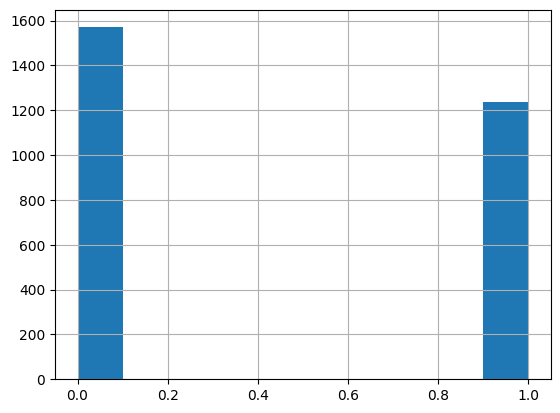

In [3]:
df_all_data['target'].hist()

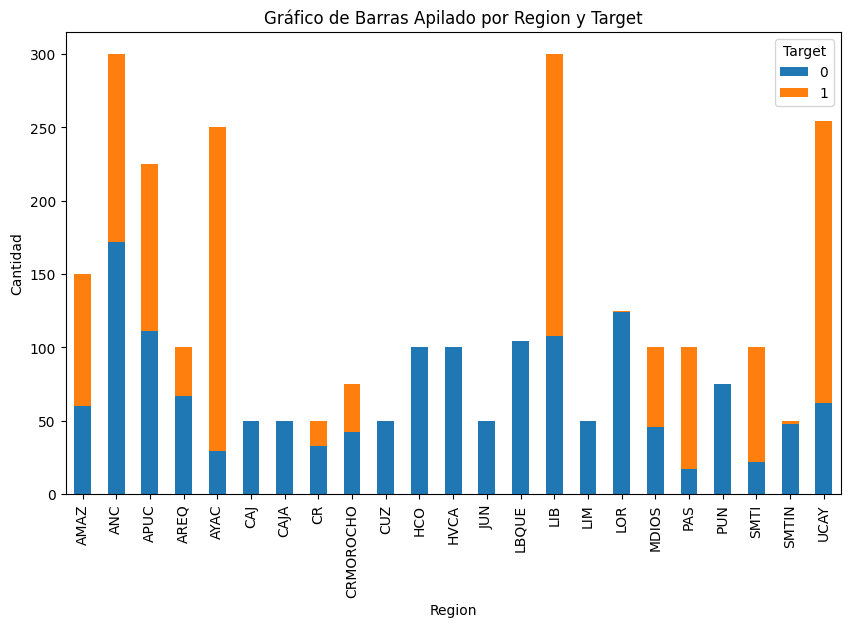

In [4]:
pivot_df = pd.pivot_table(df_all_data, index='region', columns='target', aggfunc='size', fill_value=0)

# Crear el gráfico de barras apilado
ax = pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6), color=['#1f77b4', '#ff7f0e'])

# Configurar el gráfico
ax.set_title('Gráfico de Barras Apilado por Region y Target')
ax.set_xlabel('Region')
ax.set_ylabel('Cantidad')
ax.legend(title='Target', labels=['0', '1'], loc='upper right')

# Mostrar el gráfico
plt.show()

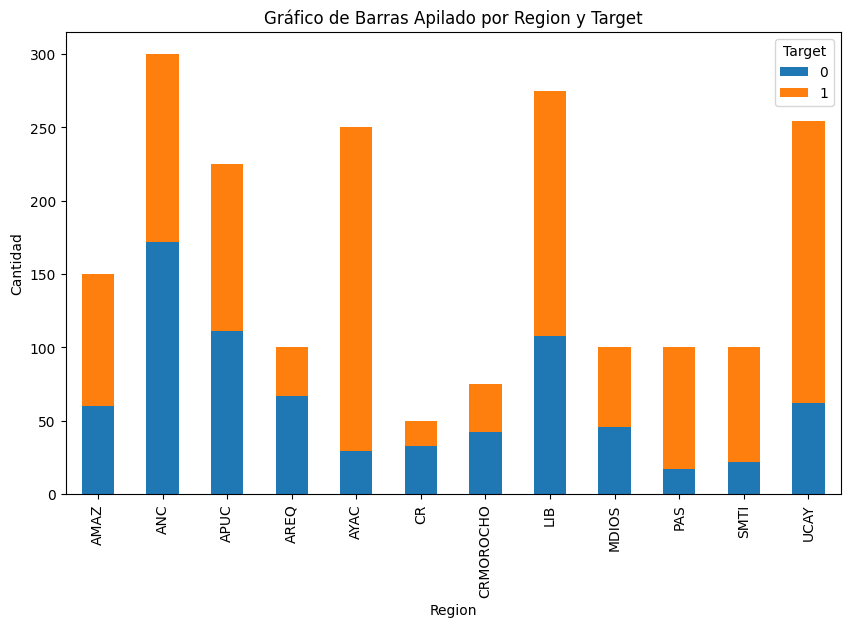

In [26]:
## Filtramos regiones con solo ceros
regions_only_zeros = ["CAJ","CAJA","CUZ","HCO","HVCA", "JUN", "LBQUE","LIM", "LOR", 'PUN', "SMTIN"]
df_all_data = df_all_data[~df_all_data['region'].isin(regions_only_zeros)].copy().reset_index(drop = True)
# filtramos imagenes mal tomadas
image_with_error = ["LIB-105-06"]
df_all_data = df_all_data[~df_all_data['name'].isin(image_with_error)].copy().reset_index(drop = True)


pivot_df = pd.pivot_table(df_all_data, index='region', columns='target', aggfunc='size', fill_value=0)

# Crear el gráfico de barras apilado
ax = pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6), color=['#1f77b4', '#ff7f0e'])

# Configurar el gráfico
ax.set_title('Gráfico de Barras Apilado por Region y Target')
ax.set_xlabel('Region')
ax.set_ylabel('Cantidad')
ax.legend(title='Target', labels=['0', '1'], loc='upper right')

# Mostrar el gráfico
plt.show()

In [27]:
from sklearn.model_selection import train_test_split
## Split data
images_seeds_files = df_all_data["file_seed"]
labels = df_all_data["target"]

X_train_files, X_test_files, y_train , y_test = train_test_split(images_seeds_files.values.tolist(), labels.values, test_size= 0.3, shuffle = True, stratify=labels)


## Pca processing

In [28]:
import rasterio
import pandas as pd
import numpy as np
import os
def read_pixels_hsi_images(images_seeds_paths):
    df_pixels = pd.DataFrame()
    i = 1
    for image_path in images_seeds_paths:
        dataset = rasterio.open(image_path)
        frame_bands = dataset.read()
        (bands, h, w) = frame_bands.shape
        data_features = frame_bands.reshape((bands, h * w)).transpose(1,0) #  (h *w , 240)
        df_pixels = pd.concat([df_pixels, pd.DataFrame(data_features)])
        
        print(i," del total de: ", len(images_seeds_paths))
        i = i+1
    return df_pixels


data_hsi_dir = "C:/Users/ileon/ProyectoMaizBase/seeds"
images_seeds_paths = [ os.path.join(data_hsi_dir, hsi_file) for hsi_file in X_train_files]
#df_pixels = read_pixels_hsi_images(images_seeds_paths)

In [10]:
#from sklearn.decomposition import PCA
#n_components = 3
#pca = PCA(n_components = 3)
#pca.fit(df_pixels.values)

#print("pca.explained_variance_ratio_:", pca.explained_variance_ratio_)

In [29]:
from sklearn.decomposition import PCA

def pca_image_processing(hci_image, pca_module = None, n_components = 3, return_weights = False):
    (bands, h, w) = hci_image.shape
    data_features = hci_image.reshape((bands, h * w)).transpose(1,0) #  (h *w , 240)
    
    if pca_module is None:
        pca = PCA(n_components = n_components)
        pca_image = pca.fit_transform(data_features)
    else:
        pca_image = pca_module.transform(data_features)

    pca_image = pca_image.reshape(h, w, n_components)
    
    if return_weights:
        print("pca.explained_variance_ratio_:", pca.explained_variance_ratio_)
        return pca_image, pca.components_
    return pca_image

dataset = rasterio.open(images_seeds_paths[-5])
hci_image = dataset.read()

start_length_wave = 20
n_components_pca = 5
hci_image = hci_image[start_length_wave:,:,:]
pca_image, pca_weights = pca_image_processing(hci_image, n_components=n_components_pca, return_weights = True)
print("Image Shape:", pca_image.shape)

pca.explained_variance_ratio_: [9.8320603e-01 1.3181923e-02 3.1369547e-03 2.8784340e-04 8.7941153e-05]
Image Shape: (95, 103, 5)


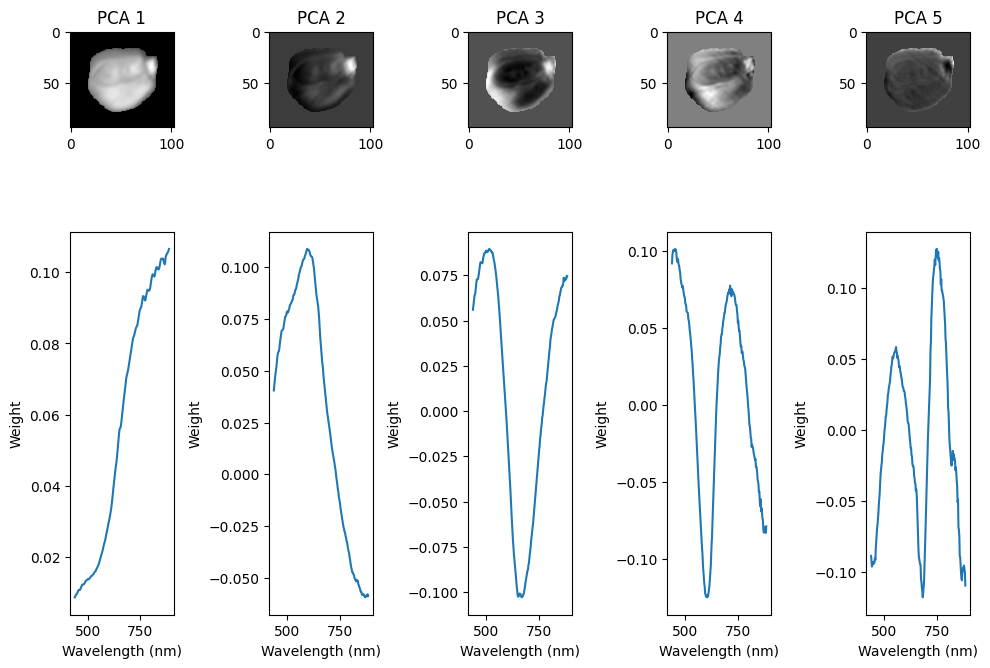

In [30]:
import matplotlib.pyplot as plt
long_onda = [395.62, 397.6728, 399.7256, 401.7784, 403.8312, 405.884, 407.9368, 409.9896, 412.0424, 414.0952, 416.148, 418.2008, 420.2536, 422.3064, 424.3592, 426.412, 428.4648, 430.5176, 432.5704, 434.6232, 436.676, 438.7288, 440.7816, 442.8344, 444.8872, 446.94, 448.9928, 451.0456, 453.0984, 455.1512, 457.204, 459.2568, 461.3096, 463.3624, 465.4152, 467.468, 469.5208, 471.5736, 473.6264, 475.6792, 477.732, 479.7848, 481.8376, 483.8904, 485.9432, 487.996, 490.0488, 492.1016, 494.1544, 496.2072, 498.26, 500.3128, 502.3656, 504.4184, 506.4712, 508.524, 510.5768, 512.6296, 514.6824, 516.7352, 518.788, 520.8408, 522.8936, 524.9464, 526.9992, 529.052, 531.1048, 533.1576, 535.2104, 537.2632, 539.316, 541.3688, 543.4216, 545.4744, 547.5272, 549.58, 551.6328, 553.6856, 555.7384, 557.7912, 559.844, 561.8968, 563.9496, 566.0024, 568.0552, 570.108, 572.1608, 574.2136, 576.2664, 578.3192, 580.372, 582.4248, 584.4776, 586.5304, 588.5832, 590.636, 592.6888, 594.7416, 596.7944, 598.8472, 600.9, 602.9528, 605.0056, 607.0584, 609.1112, 611.164, 613.2168, 615.2696, 617.3224, 619.3752, 621.428, 623.4808, 625.5336, 627.5864, 629.6392, 631.692, 633.7448, 635.7976, 637.8504, 639.9032, 641.956, 644.0088, 646.0616, 648.1144, 650.1672, 652.22, 654.2728, 656.3256, 658.3784, 660.4312, 662.484, 664.5368, 666.5896, 668.6424, 670.6952, 672.748, 674.8008, 676.8536, 678.9064, 680.9592, 683.012, 685.0648, 687.1176, 689.1704, 691.2232, 693.276, 695.3288, 697.3816, 699.4344, 701.4872, 703.54, 705.5928, 707.6456, 709.6984, 711.7512, 713.804, 715.8568, 717.9096, 719.9624, 722.0152, 724.068, 726.1208, 728.1736, 730.2264, 732.2792, 734.332, 736.3848, 738.4376, 740.4904, 742.5432, 744.596, 746.6488, 748.7016, 750.7544, 752.8072, 754.86, 756.9128, 758.9656, 761.0184, 763.0712, 765.124, 767.1768, 769.2296, 771.2824, 773.3352, 775.388, 777.4408, 779.4936, 781.5464, 783.5992, 785.652, 787.7048, 789.7576, 791.8104, 793.8632, 795.916, 797.9688, 800.0216, 802.0744, 804.1272, 806.18, 808.2328, 810.2856, 812.3384, 814.3912, 816.444, 818.4968, 820.5496, 822.6024, 824.6552, 826.708, 828.7608, 830.8136, 832.8664, 834.9192, 836.972, 839.0248, 841.0776, 843.1304, 845.1832, 847.236, 849.2888, 851.3416, 853.3944, 855.4472, 857.5, 859.5528, 861.6056, 863.6584, 865.7112, 867.764, 869.8168, 871.8696, 873.9224, 875.9752, 878.028, 880.0808, 882.1336, 884.1864, 886.2392]

def plot_pca_weights(axis, pca_n_weights):
    x = long_onda[start_length_wave:]
    y = pca_n_weights
    axis.plot(x, y)
    axis.set_ylabel("Weight")
    axis.set_xlabel("Wavelength (nm)")

def plot_pca_components(pca_image , pca_weights = None , n_components = 3, figsize = (10,8)):
    nrows = 2 if pca_weights is not None else 1
    ncols = n_components
    fig, axis = plt.subplots(nrows=nrows, ncols=ncols, figsize = figsize)
    for i in range(ncols):
      
        if pca_weights is not None:
            axis[0,i].imshow(pca_image[:,:,i], cmap = "gray")
            axis[0,i].set_title("PCA "  + str(i + 1))
            plot_pca_weights(axis[1,i], pca_weights[i,:])
        else:
            axis[i].imshow(pca_image[:,:,i], cmap = "gray")
            axis[i].set_title("PCA "  + str(i + 1))
        #axis[i,0].imshow(pca_image[:,:,i])
    plt.tight_layout()
    plt.show()
    
plot_pca_components(pca_image, pca_weights = pca_weights,  n_components = 5)    

# Data Generator

In [39]:
import os
import numpy as np
from tensorflow import keras
import rasterio

class HyperspectralDataGenerator(keras.utils.Sequence):
    def __init__(self,
        data_dir, 
        file_list, 
        label_list, 
        image_shape, 
        batch_size=32, 
        shuffle=True):
        self.data_dir = data_dir
        self.file_list = file_list
        self.label_list = label_list
        self.image_shape = image_shape
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.file_list))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.ceil(len(self.file_list) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_indices = self.indexes[start:end]
        X, y = self.__data_generation(batch_indices)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_indices):
        X = np.zeros((len(batch_indices), *self.image_shape), dtype=np.float32)
        y = np.zeros(len(batch_indices), dtype=int)

        for i, file_index in enumerate(batch_indices):
            file_path = os.path.join(self.data_dir, self.file_list[file_index])
            #print("\nfile_path:", file_path)
            dataset = rasterio.open(file_path)
            hci_image = dataset.read()
            hci_image = hci_image[30:,:,:]
            pca_image = pca_image_processing(hci_image, n_components=5)
            #print("pca_image:", pca_image.shape)
            h, w, _ = pca_image.shape
            
            if w > image_shape[1]:
                dy = (w - self.image_shape[1])//2
                pca_image = pca_image[:, dy:self.image_shape[1] + dy, :]
                w = self.image_shape[1]

            if h > image_shape[0]:
                dx = (h - self.image_shape[0])//2
                pca_image = pca_image[dx:self.image_shape[0] + dx,:, :]
                h = self.image_shape[0]

            #print("pca_image:", pca_image.shape)
            
            ## Rellenar im
            dx = (self.image_shape[1]-w)//2
            dy = (self.image_shape[0]-h)//2

            #print("dx:", dx)
            #print("dy:", dy)
            #print("pca_image:",pca_image.shape)
            X[i][dy:dy+h, dx:dx+w] = pca_image
            y[i] = self.label_list[file_index]
        #print("X",X.shape)

        return X, y

array([[ 68, 234, 219],
       [ 71, 234, 161],
       [103, 234, 337],
       [104, 234, 212],
       [106, 234, 438],
       [107, 234, 530]], dtype=int64)

C:\Users\ileon\AppData\Roaming\Python\Python39\site-packages\matplotlib\image.py:492: RuntimeWarning: invalid value encountered in subtract
  A_scaled -= a_min


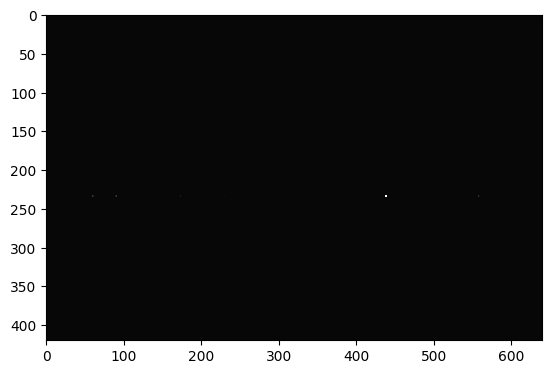

In [40]:
im_path = "C:/Users/ileon/ProyectoMaizBase/seeds\LIB-105-06-SEED-12.bil"
im_full = "C:/Users/ileon/ProyectoMaizBase/all_images/LIB-105-06.bil"
dataset = rasterio.open(im_full)
hci_image = dataset.read()
plt.imshow(hci_image[106,:,:], cmap = "gray")
#pca_image = pca_image_processing(hci_image, n_components=5)
#pca_image
np.argwhere(np.isnan(hci_image))

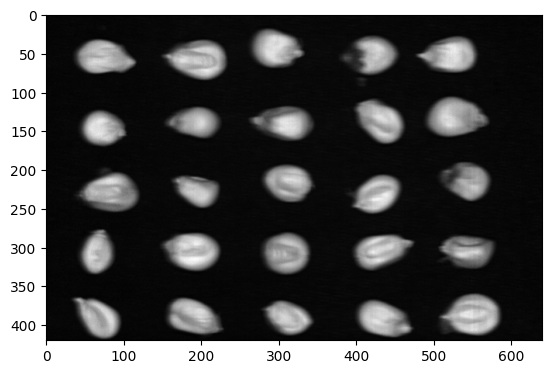

In [41]:
plt.imshow(hci_image[100,:,:], cmap = "gray")

In [42]:
image_shape = (128, 128, n_components_pca)  # Ajusta las dimensiones de tus imágenes hiperespectrales
batch_size = 4

In [43]:
data_dir = data_hsi_dir

train_generator = HyperspectralDataGenerator(data_dir, X_train_files, y_train, image_shape, batch_size)

test_generator = HyperspectralDataGenerator(data_dir, X_test_files, y_test, image_shape, batch_size)


In [44]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import backend as K

# Crear un modelo secuencial
model = keras.Sequential([  
    Conv2D(64, (3, 3), activation='relu', input_shape=image_shape),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
    ]
)

def f1_metric(y_true, y_pred):
    y_pred = K.round(y_pred)
    f1 = 2 * (K.sum(y_true * y_pred) + K.epsilon()) / (K.sum(y_true) + K.sum(y_pred) + K.epsilon())
    return f1

checkpoint_filepath = "./best_model.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_f1_metric',
    mode='max',
    save_best_only=True)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_metric])

# Resumen del modelo
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 126, 64)      2944      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 63, 63, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 128)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 256)       295168    
                                                                 
 flatten_2 (Flatten)         (None, 200704)           

In [45]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

history = model.fit(train_generator, 
                    epochs=20, 
                    batch_size=batch_size,
                    validation_data=test_generator,
                    #class_weight={0: 1, 1:2},
                    callbacks=[model_checkpoint_callback]
                   )

Epoch 1/20
347/347 [==============================] - 615s 2s/step - loss: 1.0689 - accuracy: 0.6094 - f1_metric: 0.7175 - val_loss: 0.6940 - val_accuracy: 0.6111 - val_f1_metric: 0.7181
Epoch 2/20
347/347 [==============================] - 308s 889ms/step - loss: 0.9044 - accuracy: 0.6130 - f1_metric: 0.7283 - val_loss: 0.7439 - val_accuracy: 0.6111 - val_f1_metric: 0.7279
Epoch 3/20
347/347 [==============================] - 309s 891ms/step - loss: 0.9063 - accuracy: 0.6108 - f1_metric: 0.7270 - val_loss: 0.8397 - val_accuracy: 0.6111 - val_f1_metric: 0.7283
Epoch 4/20
347/347 [==============================] - 309s 891ms/step - loss: 0.8962 - accuracy: 0.6116 - f1_metric: 0.7317 - val_loss: 0.6725 - val_accuracy: 0.6111 - val_f1_metric: 0.7314
Epoch 5/20
347/347 [==============================] - 311s 895ms/step - loss: 0.8942 - accuracy: 0.6144 - f1_metric: 0.7270 - val_loss: 0.7058 - val_accuracy: 0.6094 - val_f1_metric: 0.7278
Epoch 6/20
347/347 [==============================] -

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

# Obtener las métricas de pérdida y precisión para el conjunto de entrenamiento y prueba
loss = history.history['loss']
f1_metric = history.history['f1_metric']
val_loss = history.history['val_loss']  # Pérdida de validación
val_f1_metric = history.history['val_f1_metric']  # Precisión de validación

# Crear gráficos
plt.figure(figsize=(12, 4))

# Gráfico de pérdida
plt.subplot(1, 2, 1)
plt.plot(range(1, len(loss) + 1), loss, label='Pérdida de entrenamiento', color='blue')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Pérdida de prueba', color='red')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Gráfico de precisión
plt.subplot(1, 2, 2)
plt.plot(range(1, len(f1_metric) + 1), f1_metric, label='f1 score de entrenamiento', color='blue')
plt.plot(range(1, len(val_f1_metric) + 1), val_f1_metric, label='f1 score de prueba', color='red')
plt.title('f1 score durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('f1 score')
plt.legend()

plt.tight_layout()
plt.show()